# Main notebook to process indexed datasets into summaries.

## Generate sentence pairs

In [187]:
import itertools
import json
import nltk
import pandas as pd

In [188]:
save_dir = input("enter path to base directory to save outputs to:\n")

enter path to base directory to save outputs to:
 ../data/test4


In [189]:
input_path = input("enter path to indexed dataset:\n")  # default encoding is utf-8
with open(input_path) as f:
    sents_df = pd.read_csv(f, delimiter=',')
sents_df.head()

enter path to indexed dataset:
 ../data/test4/Astro1_decomposed.csv


,index,sentence
0,0,You are consistent.
1,1,You are reliable.
2,2,You tend to be dependable.
3,3,You are patient unless someone takes you too far.
4,4,You are usually slow to anger unless someone t...


In [190]:
indices = list(sents_df.index)

# generate all pairs in the set of sentences.
indices_list = list(itertools.combinations(indices, 2))
print('no. of sentences: ', len(indices))
print('no. of sentence pairs: ', len(indices_list), '\n')

no. of sentences:  47
no. of sentence pairs:  1081 



In [191]:
# generate all sentence pairs and save into a csv for manual labelling.
data = []
for pair in indices_list:
    data.append([pair[0], pair[1], sents_df.iloc[pair[0]]['sentence'], sents_df.iloc[pair[1]]['sentence']])

df = pd.DataFrame(data=data, columns=['first_index', 'second_index', 'first', 'second'])
display(df)

,first_index,second_index,first,second
0,0,1,You are consistent.,You are reliable.
1,0,2,You are consistent.,You tend to be dependable.
2,0,3,You are consistent.,You are patient unless someone takes you too far.
3,0,4,You are consistent.,You are usually slow to anger unless someone t...
4,0,5,You are consistent.,"You tend to be industrious, efficient, practic..."
...,...,...,...,...
1076,43,45,You can handle more of the workload than most ...,You are independent.
1077,43,46,You can handle more of the workload than most ...,You are shy.
1078,44,45,You may be a bit of a perfectionist.,You are independent.
1079,44,46,You may be a bit of a perfectionist.,You are shy.


In [192]:
is_save = input('save indexed paired dataset? (y/n):\n')
if is_save.lower() == 'y':
    df.to_csv(save_dir + '/' + 'paired_sentences.csv')
else:
    print('not saving indexed paired dataset.')

save indexed paired dataset? (y/n):
 y


## Perform inferences of distances between sentences in a sentence pair

In [10]:
import torch
from fairseq.data.data_utils import collate_tokens
from math import exp
import numpy as np

class RobertaMNLI:
    # todo: create similar wrapper classes for other NLI engines.
    # todo: create a wrapper superclass and subclass from there.
    
    def __init__(self, rel_path):
        """
        :param rel_path: relative path to pytorch hub directory.
        """
        self.output_map = {
            0: 'contradiction',
            1: 'neutral',
            2: 'entailment'
        }
        
        torch.hub.set_dir(rel_path)
        self.roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')  # works
        self.roberta.cuda()
        self.roberta.eval()
        
    def predict_one(self, S1, S2, return_probs=False):
        batch = collate_tokens(
            [self.roberta.encode(S1, S2)], pad_idx=1
        )
        logprobs = self.roberta.predict('mnli', batch)
        classes_tsr = logprobs.argmax(dim=1)
        classes = classes_tsr.tolist()  
        
        if return_probs == True:
            logprobs_list=[logprob.item() for logprob in logprobs[0]]
            prob_list =  [pow(exp(1), logprob) for logprob in logprobs_list]
            return prob_list
        else:
            return classes[0]  # 0 is contradiction, 1 is neutral, 2 is entailment.

In [11]:
predictor = RobertaMNLI(rel_path="../../roberta/hub")

Using cache found in ../../roberta/hub\pytorch_fairseq_master


In [193]:
results = list()
for i in range(len(df)):
    s1 = df.iloc[i]['first']
    s2 = df.iloc[i]['second']
    CNE1 = predictor.predict_one(s1, s2, return_probs=True)
    CNE2 = predictor.predict_one(s2, s1, return_probs=True)
    row = CNE1+ CNE2
    results.append(row)

scores_df = pd.DataFrame(data=results, columns=['C1', 'N1', 'E1', 'C2', 'N2', 'E2'])

In [194]:
def gen_dist2(row):
    '''
    Generate distance score based on Contradiction, Entailment and Neutrality probabilities for both directions.
    Assumes that C+E+N=1.
    '''    
    max1 = max([row['C1'], row['E1'], row['N1']])
    max2 = max([row['C2'], row['E2'], row['N2']])
    if max1 > max2:
        C, E, N = row['C1'], row['E1'], row['N1']
    else:
        C, E, N = row['C2'], row['E2'], row['N2']
    
    if C > 0.5:
        return C
    elif C == E:
        return 0.5
    else:
        return N/(N+E)*0.5

In [195]:
dist_ser = scores_df.apply(lambda row: gen_dist2(row), axis=1)
dist_ser.name = 'dist'
scores_df = scores_df.join(dist_ser)
scores_df = df.join(scores_df)
scores_df.to_csv(save_dir + '/' + 'nliScores.csv')

In [196]:
scores_df.head()

,first_index,second_index,first,second,C1,N1,E1,C2,N2,E2,dist
0,0,1,You are consistent.,You are reliable.,0.000472,0.024263,0.975264,0.000486,0.019358,0.980157,0.009683
1,0,2,You are consistent.,You tend to be dependable.,0.000582,0.065716,0.933702,0.000632,0.036170,0.963198,0.018096
2,0,3,You are consistent.,You are patient unless someone takes you too far.,0.004675,0.977356,0.017969,0.040609,0.214119,0.745272,0.490973
3,0,4,You are consistent.,You are usually slow to anger unless someone t...,0.004078,0.993417,0.002505,0.538609,0.270079,0.191312,0.498743
4,0,5,You are consistent.,"You tend to be industrious, efficient, practic...",0.004214,0.525058,0.470728,0.001875,0.156275,0.841850,0.078284


## Clustering based on precomputed pairwise distances.

In [197]:
import numpy as np
import pandas as pd

import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

import sklearn
# from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.preprocessing import scale

# Configure the output
np.set_printoptions(precision=4,suppress=True)
%matplotlib inline
rcParams["figure.figsize"] =20,10
sb.set_style("whitegrid")

In [198]:
# convert this original dataframe to a 'square' distance matrix.
# we utilise a pivot table to do this

# first, add the redundant pairs (two of the same sentences) to the data.
# we need this for the pivot function to generate the correct indices and columns.
first = np.unique(df['first_index'].values)
second = np.unique(df['second_index'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])
add_data = add_data.astype(np.int)

print(add_data)

[[ 0  0  0]
 [ 1  1  0]
 [ 2  2  0]
 [ 3  3  0]
 [ 4  4  0]
 [ 5  5  0]
 [ 6  6  0]
 [ 7  7  0]
 [ 8  8  0]
 [ 9  9  0]
 [10 10  0]
 [11 11  0]
 [12 12  0]
 [13 13  0]
 [14 14  0]
 [15 15  0]
 [16 16  0]
 [17 17  0]
 [18 18  0]
 [19 19  0]
 [20 20  0]
 [21 21  0]
 [22 22  0]
 [23 23  0]
 [24 24  0]
 [25 25  0]
 [26 26  0]
 [27 27  0]
 [28 28  0]
 [29 29  0]
 [30 30  0]
 [31 31  0]
 [32 32  0]
 [33 33  0]
 [34 34  0]
 [35 35  0]
 [36 36  0]
 [37 37  0]
 [38 38  0]
 [39 39  0]
 [40 40  0]
 [41 41  0]
 [42 42  0]
 [43 43  0]
 [44 44  0]
 [45 45  0]
 [46 46  0]]


In [199]:
add_df = pd.DataFrame(data=add_data, columns=['first_index','second_index','dist'])
scores_df = scores_df.append(add_df, ignore_index=True)
df_piv = scores_df.pivot("first_index", "second_index", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

# generate pairwise matrix for saving.
intersentence = pd.DataFrame(data=dist_mat, index=df_piv.index, columns=df_piv.columns)

path = save_dir + '/' + 'pairwiseMatrix.csv'
intersentence.to_csv(path)

In [200]:
# load data files (this step can be skipped if the previous few cells have been run to produce the required data)

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/test4/pairwiseMatrix.csv")
print("loaded data from disk.")
display(df_piv.head())
df_piv = df_piv.drop(columns=['first_index'])
display(df_piv.head())
dist_mat = df_piv.values
display(dist_mat)

loaded data from disk.


,first_index,0,1,2,3,4,5,6,7,8,...,37,38,39,40,41,42,43,44,45,46
0,0,0.000000,0.009683,0.018096,0.490973,0.498743,0.078284,0.994419,0.492677,0.496143,...,0.998368,0.399682,0.877251,0.498560,0.492295,0.422655,0.491666,0.496580,0.132252,0.860458
1,1,0.009683,0.000000,0.007001,0.491422,0.498445,0.350313,0.882926,0.912583,0.490530,...,0.994155,0.369025,0.869252,0.497108,0.487843,0.446308,0.494564,0.498223,0.107747,0.970994
2,2,0.018096,0.007001,0.000000,0.487923,0.477068,0.099257,0.988017,0.942096,0.881199,...,0.991583,0.163785,0.463569,0.474135,0.483073,0.441268,0.469502,0.493253,0.882917,0.908823
3,3,0.490973,0.491422,0.487923,0.000000,0.007679,0.498411,0.493325,0.496423,0.497192,...,0.945772,0.491735,0.494618,0.494332,0.450308,0.939172,0.498759,0.492892,0.493068,0.493188
4,4,0.498743,0.498445,0.477068,0.007679,0.000000,0.498638,0.494649,0.494720,0.494135,...,0.499050,0.491037,0.497422,0.498741,0.484315,0.499179,0.499295,0.496972,0.499113,0.494452


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0.000000,0.009683,0.018096,0.490973,0.498743,0.078284,0.994419,0.492677,0.496143,0.495870,...,0.998368,0.399682,0.877251,0.498560,0.492295,0.422655,0.491666,0.496580,0.132252,0.860458
1,0.009683,0.000000,0.007001,0.491422,0.498445,0.350313,0.882926,0.912583,0.490530,0.499268,...,0.994155,0.369025,0.869252,0.497108,0.487843,0.446308,0.494564,0.498223,0.107747,0.970994
2,0.018096,0.007001,0.000000,0.487923,0.477068,0.099257,0.988017,0.942096,0.881199,0.493388,...,0.991583,0.163785,0.463569,0.474135,0.483073,0.441268,0.469502,0.493253,0.882917,0.908823
3,0.490973,0.491422,0.487923,0.000000,0.007679,0.498411,0.493325,0.496423,0.497192,0.498191,...,0.945772,0.491735,0.494618,0.494332,0.450308,0.939172,0.498759,0.492892,0.493068,0.493188
4,0.498743,0.498445,0.477068,0.007679,0.000000,0.498638,0.494649,0.494720,0.494135,0.495062,...,0.499050,0.491037,0.497422,0.498741,0.484315,0.499179,0.499295,0.496972,0.499113,0.494452


array([[0.    , 0.0097, 0.0181, ..., 0.4966, 0.1323, 0.8605],
       [0.0097, 0.    , 0.007 , ..., 0.4982, 0.1077, 0.971 ],
       [0.0181, 0.007 , 0.    , ..., 0.4933, 0.8829, 0.9088],
       ...,
       [0.4966, 0.4982, 0.4933, ..., 0.    , 0.4986, 0.4964],
       [0.1323, 0.1077, 0.8829, ..., 0.4986, 0.    , 0.9991],
       [0.8605, 0.971 , 0.9088, ..., 0.4964, 0.9991, 0.    ]])

In [201]:
from scipy.spatial.distance import squareform
condensed_mat = squareform(dist_mat)
linkage = 'complete'

sil_scores = []  # silhouette scores
for i in range(2, len(dist_mat)):
    clusters = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage=linkage)
    clusters.fit_predict(dist_mat)

    # use metric to measure/compare goodness of clusters based on internal coherence and 
    # external coupling.
    # consider Dunn index. maximise the Dunn index.
    # or consider average sillhouette width (maximise). available in sklearn.
    from sklearn.metrics import silhouette_score

    silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(i, ": ", silhouette_avg)

2 :  0.1530974104929932
3 :  0.11465585326025593
4 :  0.12269240201181605
5 :  0.11190740922605884
6 :  0.12398198191345929
7 :  0.1568873791468425
8 :  0.1664863247513181
9 :  0.20243131533107017
10 :  0.22778354545278098
11 :  0.23299565653457616
12 :  0.25505047055312385
13 :  0.24777594583731236
14 :  0.2601765494083113
15 :  0.280998209973779
16 :  0.3404072502709817
17 :  0.3802797934494407
18 :  0.35102645284533196
19 :  0.3657036419923493
20 :  0.34736494261303963
21 :  0.4314825522568258
22 :  0.4732499155872001
23 :  0.4992369642647755
24 :  0.5203224403720828
25 :  0.5442404595475581
26 :  0.546223550341764
27 :  0.5641998363009654
28 :  0.5623563155283867
29 :  0.5583839087212443
30 :  0.5525103870593224
31 :  0.5228773407545035
32 :  0.4847228790308328
33 :  0.45451291991996257
34 :  0.419183369272193
35 :  0.38901510001825895
36 :  0.3709636952323824
37 :  0.3481891567083235
38 :  0.30797853436851735
39 :  0.2652056622372173
40 :  0.23303602402470835
41 :  0.2156586179348

In [202]:
sil_scores_arr = np.asarray(sil_scores)
print('max avg silhouette score: ', sil_scores_arr.max())
OPTIMAL_K = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
print('nclusters w max avg silhouette score: ', OPTIMAL_K)

max avg silhouette score:  0.5641998363009654
nclusters w max avg silhouette score:  27


In [203]:
selected_k = OPTIMAL_K
clusters = AgglomerativeClustering(n_clusters=selected_k, affinity='precomputed', linkage=linkage)
clusters.fit_predict(dist_mat)
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(sents_df.iloc[idx]['sentence'])
    print('\n')

cluster 0 (size 2):
[17 19]


'Your mind is deep.'

'You grasp concepts easily.'



cluster 1 (size 2):
[34 38]


'You never find it difficult to change your mind or course in mid-stream.'

'You tend to be honest.'



cluster 2 (size 3):
[36 37 45]


'You are courageous.'

'You are adventurous.'

'You are independent.'



cluster 3 (size 2):
[32 46]


'You are quiet.'

'You are shy.'



cluster 4 (size 2):
[24 39]


'You are sentimental.'

'You are sensitive.'



cluster 5 (size 2):
[15 22]


'Your mind is analytical.'

'you probably have a good head for numbers.'



cluster 6 (size 2):
[20 30]


'You tend to be friendly.'

'You are gentle.'



cluster 7 (size 2):
[16 18]


'you dislike dirt.'

'you dislike messes.'



cluster 8 (size 2):
[ 9 10]


'Your work is usually neat.'

'Your work is usually orderly.'



cluster 9 (size 2):
[5 6]


'You tend to be industrious, efficient, practical, exacting, scientific, organized, shy, thrifty, studious, economical, and punctual.'

'You tend to be versatile.'



cluster 10 (size 2):
[23 42]


'You never give up.'

'Whatever you have set your sights on, you refuse to give up or let go of it.'



cluster 11 (size 3):
[0 1 2]


'You are consistent.'

'You are reliable.'

'You tend to be dependable.'



cluster 12 (size 3):
[ 7  8 26]


'You tend to be idealistic.'

'You tend to be optimistic.'

'You tend to be open-minded.'



cluster 13 (size 2):
[27 29]


'You are usually outspoken, sometimes to the point of bluntness.'

'You are very direct in thought, action, and speech and everyone knows how you feel.'



cluster 14 (size 1):
[28]


"You may become impatient with those who do n't learn as quickly."



cluster 15 (size 2):
[11 12]


'You prefer a regular routine, defined responsibilities.'

'You prefer a regular routine, defined tasks.'



cluster 16 (size 2):
[13 14]


'You have common sense to manage others.'

'You have the ability to manage others.'



cluster 17 (size 1):
[21]


'You are romantic.'



cluster 18 (size 1):
[44]


'You may be a bit of a perfectionist.'



cluster 19 (size 1):
[31]


'Debate and argument appeal to you.'



cluster 20 (size 2):
[3 4]


'You are patient unless someone takes you too far.'

'You are usually slow to anger unless someone takes you too far.'



cluster 21 (size 1):
[40]


'You enjoy building and seeing the results of your hard work.'



cluster 22 (size 1):
[35]


'Money and possessions are important to you for the feelings of security they bring.'



cluster 23 (size 1):
[25]


'You may be ambidextrous or mechanically inclined.'



cluster 24 (size 1):
[41]


'Keeping things going is your strength, especially once someone else starts them.'



cluster 25 (size 1):
[43]


'You can handle more of the workload than most around you.'



cluster 26 (size 1):
[33]


'You are handy with your hands.'

In [204]:
# save clusters into JSON dict
clusters_dict = dict()
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    sents = list()
    for idx in indices:
        sents.append(int(df_piv.index[idx]))
    clusters_dict[i] = sents

path = save_dir + '/' + 'clusters.json'
with open(path, 'w') as fp:
    json.dump(clusters_dict, fp)

In [205]:
# Compute the distance of one cluster to another cluster by the average pairwise distance
# of the elements in one cluster and another cluster.  
for n_clusters in [selected_k]:
    print('------')
    print(f'\nno. of clusters = {n_clusters}')
    clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage=linkage)
    clusters.fit_predict(dist_mat)
    
    # find average distances between clusters and output a new distance matrix
    labels = [i for i in range(clusters.n_clusters_)]
    avg_dist_arr = np.zeros(shape=(clusters.n_clusters_, clusters.n_clusters_))
    for i in range(clusters.n_clusters_):
        indices = np.where(clusters.labels_ == i)[0]
        labels.remove(i)
        for j in labels:
            other_indices = np.where(clusters.labels_ == j)[0]
            intra_dist_arr = np.zeros(shape=(len(indices), len(other_indices)))
            
            for k, index in enumerate(indices):
                for m, other_index in enumerate(other_indices):
                    intra_dist_arr[k][m] = dist_mat[index][other_index]
            
            #print (f'cluster {i} against cluster {j}:')
            #print(intra_dist_arr)
            
            avg_dist = np.average(intra_dist_arr)
            #print(avg_dist)
            avg_dist_arr[i][j] = avg_dist
    print(avg_dist_arr)

------

no. of clusters = 27
[[0.     0.4736 0.4592 0.6985 0.44   0.5742 0.4878 0.548  0.4935 0.4613
  0.4831 0.4714 0.4933 0.4577 0.4995 0.488  0.4858 0.4684 0.4986 0.4926
  0.4979 0.4987 0.4951 0.4853 0.4964 0.4957 0.4694]
 [0.     0.     0.5052 0.8286 0.7059 0.4517 0.6289 0.5663 0.7244 0.4503
  0.5819 0.6493 0.577  0.5679 0.4994 0.7005 0.4879 0.6468 0.747  0.4873
  0.5676 0.5102 0.7172 0.4592 0.7162 0.4854 0.4932]
 [0.     0.     0.     0.9058 0.9887 0.5626 0.7773 0.7291 0.616  0.4458
  0.2859 0.584  0.4145 0.5731 0.4993 0.6507 0.4701 0.9132 0.6607 0.475
  0.6371 0.4967 0.6232 0.4693 0.4912 0.488  0.3906]
 [0.     0.     0.     0.     0.6205 0.8002 0.5333 0.4865 0.4983 0.5296
  0.936  0.6181 0.7448 0.9994 0.4993 0.4791 0.684  0.9815 0.4974 0.9865
  0.4942 0.6456 0.4935 0.4439 0.7026 0.6666 0.8854]
 [0.     0.     0.     0.     0.     0.8509 0.371  0.4698 0.4955 0.8461
  0.6213 0.7219 0.6497 0.9537 0.4988 0.4823 0.7015 0.348  0.483  0.6832
  0.4931 0.4801 0.4886 0.4394 0.5663 0.6443 

In [206]:
path = save_dir + '/' + 'clusterDistances.csv'
intercluster_dists = avg_dist_arr + np.transpose(avg_dist_arr)
np.savetxt(path, intercluster_dists, delimiter=",")

In [207]:
print(intercluster_dists)

[[0.     0.4736 0.4592 0.6985 0.44   0.5742 0.4878 0.548  0.4935 0.4613
  0.4831 0.4714 0.4933 0.4577 0.4995 0.488  0.4858 0.4684 0.4986 0.4926
  0.4979 0.4987 0.4951 0.4853 0.4964 0.4957 0.4694]
 [0.4736 0.     0.5052 0.8286 0.7059 0.4517 0.6289 0.5663 0.7244 0.4503
  0.5819 0.6493 0.577  0.5679 0.4994 0.7005 0.4879 0.6468 0.747  0.4873
  0.5676 0.5102 0.7172 0.4592 0.7162 0.4854 0.4932]
 [0.4592 0.5052 0.     0.9058 0.9887 0.5626 0.7773 0.7291 0.616  0.4458
  0.2859 0.584  0.4145 0.5731 0.4993 0.6507 0.4701 0.9132 0.6607 0.475
  0.6371 0.4967 0.6232 0.4693 0.4912 0.488  0.3906]
 [0.6985 0.8286 0.9058 0.     0.6205 0.8002 0.5333 0.4865 0.4983 0.5296
  0.936  0.6181 0.7448 0.9994 0.4993 0.4791 0.684  0.9815 0.4974 0.9865
  0.4942 0.6456 0.4935 0.4439 0.7026 0.6666 0.8854]
 [0.44   0.7059 0.9887 0.6205 0.     0.8509 0.371  0.4698 0.4955 0.8461
  0.6213 0.7219 0.6497 0.9537 0.4988 0.4823 0.7015 0.348  0.483  0.6832
  0.4931 0.4801 0.4886 0.4394 0.5663 0.6443 0.9098]
 [0.5742 0.4517 0.562

## Visualise network of clusters

In [ ]:
import networkx as nx
import string

In [ ]:
G = nx.from_numpy_matrix(tmp)
print(G.nodes())
print(G.edges().data())
#G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))

import pydot
from networkx.drawing.nx_pydot import write_dot

print("using package pydot")
path = save_dir + '/' + 'clusterViz.dot'
write_dot(G, path)
# you can then use the various graphviz CLI to generate the image. E.g. "neato -Tpng clusterViz.dot -o clusterViz.png"
# see https://www.graphviz.org/pdf/neatoguide.pdf for more info on modifying dot files.
# fdp or sfdp can be used instead of neato. 

## Summarize

In [227]:
# LOAD DATA

import numpy as np
# load indexed sentences:
sents_df = pd.read_csv("../data/test4/Astro1_decomposed.csv")

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/test4/pairwiseMatrix.csv")
df_piv = df_piv.drop(columns=['first_index'])
dist_mat = df_piv.values

# load intercluster pairwise distance matrix.
intercluster_dists = np.loadtxt("../data/test4/clusterDistances.csv", delimiter=",")

# load clusters.
with open("../data/test4/clusters.json") as fp:
    clusters_dict = json.load(fp)

    print("loaded data from disk.")

loaded data from disk.


## Reliability Ranking approach to multi-summarization.

In [209]:
clusters_dict

{'0': [17, 19],
 '1': [34, 38],
 '2': [36, 37, 45],
 '3': [32, 46],
 '4': [24, 39],
 '5': [15, 22],
 '6': [20, 30],
 '7': [16, 18],
 '8': [9, 10],
 '9': [5, 6],
 '10': [23, 42],
 '11': [0, 1, 2],
 '12': [7, 8, 26],
 '13': [27, 29],
 '14': [28],
 '15': [11, 12],
 '16': [13, 14],
 '17': [21],
 '18': [44],
 '19': [31],
 '20': [3, 4],
 '21': [40],
 '22': [35],
 '23': [25],
 '24': [41],
 '25': [43],
 '26': [33]}

In [228]:
def rank_by_reliability(clusters_dict, intercluster, contra_threshold=0.5):
    """
    :param clusters_dict: dict of clusters. {str(cluster index): list(sentence indices)}.
    :param intercluster: square numpy.ndarray representing distances between each cluster.
    
    """
    scores = list()
    for cluster_idx in range(len(intercluster)):
        contra_size = 0
        for other_cluster_idx in range(len(intercluster)):
            if intercluster[cluster_idx][other_cluster_idx] > contra_threshold:
                contra_size = contra_size + len(clusters_dict[str(other_cluster_idx)])
        numer = len(clusters_dict[str(cluster_idx)])
        if contra_size > 0:
            denom = contra_size
        else:
            denom = 1
        score = numer/denom
        scores.append((score, cluster_idx))
    return scores

In [229]:
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)

In [230]:
def intra_clust_dis_mat(clust, pairwise):
    """
    :param clust: list of sentence indices that form the cluster.
    :param pairwise: numpy.ndarray of universal pairwise dist matrix. 
    """
    sorted_clust = sorted(clust)
    pairs = list(itertools.combinations(clust, 2))
    tmp = np.zeros((len(clust), len(clust)))
    for pair in pairs:
        tmp_idx0 = sorted_clust.index(pair[0])
        tmp_idx1 = sorted_clust.index(pair[1])
        tmp[tmp_idx0][tmp_idx1] = pairwise[pair[0], pair[1]]
    tmp = tmp + np.transpose(tmp)
    return tmp, sorted_clust

In [231]:
intercluster_dists

array([[0.    , 0.4736, 0.4592, 0.6985, 0.44  , 0.5742, 0.4878, 0.548 ,
        0.4935, 0.4613, 0.4831, 0.4714, 0.4933, 0.4577, 0.4995, 0.488 ,
        0.4858, 0.4684, 0.4986, 0.4926, 0.4979, 0.4987, 0.4951, 0.4853,
        0.4964, 0.4957, 0.4694],
       [0.4736, 0.    , 0.5052, 0.8286, 0.7059, 0.4517, 0.6289, 0.5663,
        0.7244, 0.4503, 0.5819, 0.6493, 0.577 , 0.5679, 0.4994, 0.7005,
        0.4879, 0.6468, 0.747 , 0.4873, 0.5676, 0.5102, 0.7172, 0.4592,
        0.7162, 0.4854, 0.4932],
       [0.4592, 0.5052, 0.    , 0.9058, 0.9887, 0.5626, 0.7773, 0.7291,
        0.616 , 0.4458, 0.2859, 0.584 , 0.4145, 0.5731, 0.4993, 0.6507,
        0.4701, 0.9132, 0.6607, 0.475 , 0.6371, 0.4967, 0.6232, 0.4693,
        0.4912, 0.488 , 0.3906],
       [0.6985, 0.8286, 0.9058, 0.    , 0.6205, 0.8002, 0.5333, 0.4865,
        0.4983, 0.5296, 0.936 , 0.6181, 0.7448, 0.9994, 0.4993, 0.4791,
        0.684 , 0.9815, 0.4974, 0.9865, 0.4942, 0.6456, 0.4935, 0.4439,
        0.7026, 0.6666, 0.8854],
    

In [232]:
from lexrank.lexrank import LexRank
from lexrank.lexrank import degree_centrality_scores

In [233]:
def choose_salient(dis_mat, sorted_clust):
    """
    :param dis_mat: disimilarity or distance matrix. every value is between 0-1, inclusive.
    :sorted_clust: sorted list of sentence indices corresponding to the indexing of dis_mat.
    :returns: sentence index of most salient sentence.
    """
    similarity_matrix = 1 - dis_mat
    #print(similarity_matrix)
    scores = degree_centrality_scores(similarity_matrix, threshold=None)
    #print(scores)
    return sorted_clust[np.argmax(scores)]

In [234]:
# print out clusters and most salient sentences for each cluster, in descending order of "reliability". 
for score, idx in sorted(scores, reverse=True):
    print(f"cluster: {idx}")
    print(f"reliability score: {score}")
    display(sents_df.iloc[clusters_dict[str(idx)]])
    intraclust, sorted_clust = intra_clust_dis_mat(clusters_dict[str(idx)], dist_mat)
    display(sents_df.iloc[choose_salient(intraclust, sorted_clust)]['sentence'])
    print()

cluster: 0
reliability score: 1.0


,index,sentence
17,17,Your mind is deep.
19,19,You grasp concepts easily.


'Your mind is deep.'


cluster: 16
reliability score: 0.4


,index,sentence
13,13,You have common sense to manage others.
14,14,You have the ability to manage others.


'You have common sense to manage others.'


cluster: 7
reliability score: 0.4


,index,sentence
16,16,you dislike dirt.
18,18,you dislike messes.


'you dislike dirt.'


cluster: 23
reliability score: 0.3333333333333333


,index,sentence
25,25,You may be ambidextrous or mechanically inclined.


'You may be ambidextrous or mechanically inclined.'


cluster: 20
reliability score: 0.2857142857142857


,index,sentence
3,3,You are patient unless someone takes you too far.
4,4,You are usually slow to anger unless someone t...


'You are patient unless someone takes you too far.'


cluster: 25
reliability score: 0.25


,index,sentence
43,43,You can handle more of the workload than most ...


'You can handle more of the workload than most around you.'


cluster: 24
reliability score: 0.25


,index,sentence
41,41,"Keeping things going is your strength, especia..."


'Keeping things going is your strength, especially once someone else starts them.'


cluster: 11
reliability score: 0.25


,index,sentence
0,0,You are consistent.
1,1,You are reliable.
2,2,You tend to be dependable.


'You are reliable.'


cluster: 8
reliability score: 0.25


,index,sentence
9,9,Your work is usually neat.
10,10,Your work is usually orderly.


'Your work is usually neat.'


cluster: 10
reliability score: 0.2222222222222222


,index,sentence
23,23,You never give up.
42,42,"Whatever you have set your sights on, you refu..."


'You never give up.'


cluster: 12
reliability score: 0.21428571428571427


,index,sentence
7,7,You tend to be idealistic.
8,8,You tend to be optimistic.
26,26,You tend to be open-minded.


'You tend to be optimistic.'


cluster: 26
reliability score: 0.2


,index,sentence
33,33,You are handy with your hands.


'You are handy with your hands.'


cluster: 21
reliability score: 0.2


,index,sentence
40,40,You enjoy building and seeing the results of y...


'You enjoy building and seeing the results of your hard work.'


cluster: 9
reliability score: 0.2


,index,sentence
5,5,"You tend to be industrious, efficient, practic..."
6,6,You tend to be versatile.


'You tend to be industrious, efficient, practical, exacting, scientific, organized, shy, thrifty, studious, economical, and punctual.'


cluster: 5
reliability score: 0.2


,index,sentence
15,15,Your mind is analytical.
22,22,you probably have a good head for numbers.


'Your mind is analytical.'


cluster: 15
reliability score: 0.18181818181818182


,index,sentence
11,11,"You prefer a regular routine, defined responsi..."
12,12,"You prefer a regular routine, defined tasks."


'You prefer a regular routine, defined responsibilities.'


cluster: 2
reliability score: 0.17647058823529413


,index,sentence
36,36,You are courageous.
37,37,You are adventurous.
45,45,You are independent.


'You are adventurous.'


cluster: 22
reliability score: 0.16666666666666666


,index,sentence
35,35,Money and possessions are important to you for...


'Money and possessions are important to you for the feelings of security they bring.'


cluster: 14
reliability score: 0.14285714285714285


,index,sentence
28,28,You may become impatient with those who do n't...


"You may become impatient with those who do n't learn as quickly."


cluster: 6
reliability score: 0.125


,index,sentence
20,20,You tend to be friendly.
30,30,You are gentle.


'You tend to be friendly.'


cluster: 13
reliability score: 0.11764705882352941


,index,sentence
27,27,"You are usually outspoken, sometimes to the po..."
29,29,"You are very direct in thought, action, and sp..."


'You are usually outspoken, sometimes to the point of bluntness.'


cluster: 1
reliability score: 0.11764705882352941


,index,sentence
34,34,You never find it difficult to change your min...
38,38,You tend to be honest.


'You never find it difficult to change your mind or course in mid-stream.'


cluster: 18
reliability score: 0.1111111111111111


,index,sentence
44,44,You may be a bit of a perfectionist.


'You may be a bit of a perfectionist.'


cluster: 4
reliability score: 0.07692307692307693


,index,sentence
24,24,You are sentimental.
39,39,You are sensitive.


'You are sentimental.'


cluster: 3
reliability score: 0.06896551724137931


,index,sentence
32,32,You are quiet.
46,46,You are shy.


'You are quiet.'


cluster: 19
reliability score: 0.05


,index,sentence
31,31,Debate and argument appeal to you.


'Debate and argument appeal to you.'


cluster: 17
reliability score: 0.05


,index,sentence
21,21,You are romantic.


'You are romantic.'

In [221]:
def summarize(clusters, intercluster, sent_df, intersentence, coherence_threshold=0.6, redundancy_threshold=0.1):
    """
    :param clusters: dict of clusters of the form {str(cluster_num): list(sentence_indices)}.
    :param intercluster: numpy.ndarray of inter-cluster distances in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param intersentence: numpy.ndarray of inter-sentence distances in pairwise matrix form.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: lowest distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception("coherence_threshold <= redundancy_threshold.")
    
    #sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    scores = rank_by_reliability(clusters, intercluster, contra_threshold=0.6) # each element is (score, cluster_index)
    sorted_clusters = sorted(scores, reverse=True)
    tmp = np.asarray([scores for scores, idx in sorted_clusters])
    
    reliable_threshold = 0.6  # a reliability score above this is deemed reliable.
    try:
        reliable_index = max(np.argwhere(tmp > reliable_threshold))[0]  # an index into sorted_clusters.
        reliable_clusters = sorted_clusters[:reliable_index+1]
    except ValueError: 
        reliable_index = -1
        reliable_clusters = None
    
    unreliable_threshold = 0.4  # a reliability score below this is deemed unreliable.
    unreliable_index = min(np.argwhere(tmp < unreliable_threshold))[0]  # an index into sorted_clusters.
    unreliable_clusters = sorted_clusters[unreliable_index+1:]
    
    contested_clusters = sorted_clusters[reliable_index+1: unreliable_index]
    
    def create_coherent_summary(ordered_clusters):
        # this summary does not contain contradictions within itself.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[str(cluster_idx)], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            salient_sent = sents_df.iloc[salient_idx]['sentence']
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence[sent_idx][salient_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(salient_idx)
        return summary
    
    def create_free_summary(ordered_clusters):
        # this summary is just formed from the most salient sentence of ea cluster. no regards to whether
        # appending the next sentence would cause the summary to be self-contradicted.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[str(cluster_idx)], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            summary.append(salient_idx)
        return summary
    
    if reliable_clusters != None:
        reliable_summary = create_coherent_summary(reliable_clusters)
    else:
        reliable_summary = []
    contested_summary = create_free_summary(contested_clusters)
    unreliable_summary = create_free_summary(unreliable_clusters)
    
    return reliable_summary, contested_summary, unreliable_summary

In [222]:
summaries = summarize(clusters_dict, intercluster_dists, sents_df, dist_mat)
print(len(summaries[0]))
print(len(summaries[1]))
print(len(summaries[2]))

0
1
25


In [223]:
def prune_and_print(summary, sent_limit):
    i = 0
    while i < sent_limit and i < len(summary):
        sent_idx = summary[len(summary)-1-i]
        print(sents_df.iloc[sent_idx]['sentence'])
        i = i + 1

In [224]:
print("MAIN SUMMARY (reliable summary statements):")
prune(summaries[0], sent_limit=5)
print()

print("most CONTESTED summary statements:")
prune(summaries[1], sent_limit=5)
print()

print("most UNRELIABLE summary statements:")
prune(summaries[2], sent_limit=5)

MAIN SUMMARY (reliable summary statements):

most CONTESTED summary statements:
Your mind is deep.

most UNRELIABLE summary statements:
You are romantic.
Debate and argument appeal to you.
You are quiet.
You are sentimental.
You may be a bit of a perfectionist.


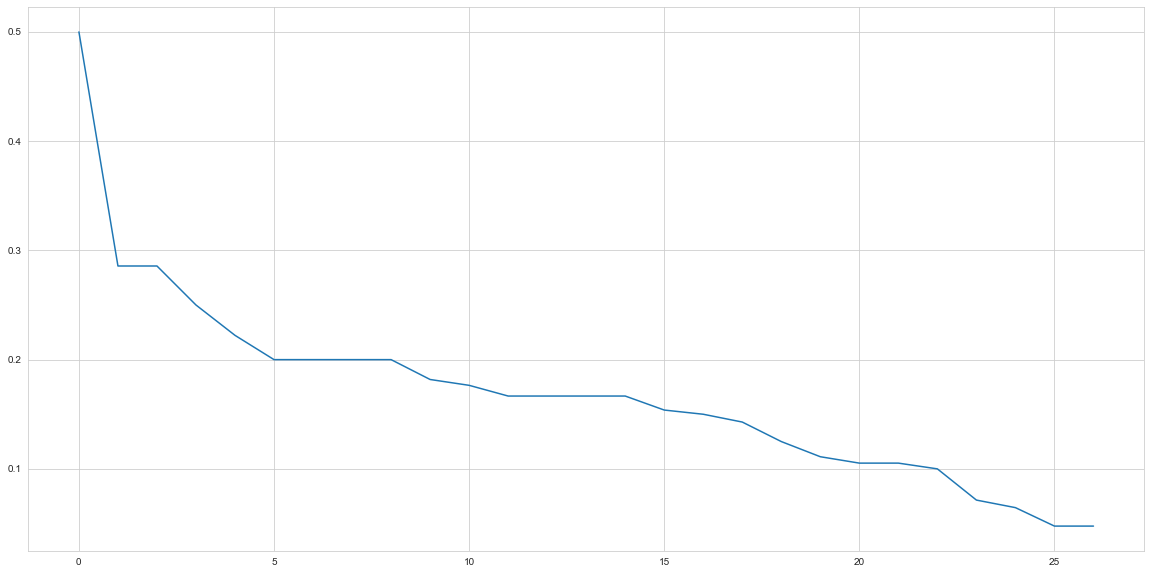

In [225]:
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)
sorted_clusters = sorted(scores, reverse=True)  # each element is (score, cluster_index)
scores_only = [score for score, _ in sorted_clusters]
import matplotlib.pyplot as plt
plt.plot(scores_only)

## Previous Single Summary Algo.

In [ ]:
from nltk.tokenize import RegexpTokenizer

def choose_longest(sentences):
    tokenizer = RegexpTokenizer(r'\w+')
    max_len = 0
    final_sent = None
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        if len(tokens) > max_len:
            max_len = len(sent)
            final_sent = sent
    return final_sent

from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
def choose_salient(sentences):
    """
    
    """
    lxr = LexRank(sentences, stopwords=STOPWORDS['en'])
    top_sentence = lxr.get_summary(sentences[0], summary_size=1, threshold=.1)
    return top_sentence[0]
    

def summarize(clusters, intersentence, sent_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.3):
    """
    :param clusters: dict of clusters of the form {str(cluster_num): list(sentence_indices)}.
    :param intersentence: Pandas DataFrame of precomputed inter-sentence distance in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: minimum distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception
    
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    summary = list()
    word_count = 0
    
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    
    for key, clust in sorted_clusters:
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        #selected = choose_longest(clust)
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        tokens = tokenizer.tokenize(selected)
        if word_count + len(tokens) < word_limit:
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence.iloc[sent_idx][selected_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(selected_idx)
                word_count = word_count + len(tokens)
        else:
            break
    return summary

In [ ]:
# test lexrank algorithm.
sentences = [sents_df.iloc[idx]['sentence'] for idx in clusters_dict['0']]
display(sentences)
choose_salient([sentences])

In [ ]:
# todo: think of statistical way to determine the coherence_threshold and redundancy_threshold.
summary = summarize(clusters_dict, intersentence, sents_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.35)
print("no. of sentences in summary: ", len(summary))
print("no. of sentences in source: ", len(intersentence.index.values))
print()
for sent_idx in summary:
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")
print()
for sent_idx in sorted(summary):
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")

## Multiple Summaries (deprecated)

In [ ]:
def multi_summary(clusters, intercluster_dists, sent_df, word_limit=100, contradiction_threshold=0.6):
    """
    :param clusters: dict of clusters of the form {str(cluster_index): list(sentence_indices)}.
    :param intercluster_dists: square numpy.ndarray representing distances between each cluster.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param contradiction_threshold: float value between 0 and 1, representing the value after which
    sentence pairs will be considered contradictory.
    """
    # find top/representative sentence of each cluster.
    top_sentences = dict()
    for clust_idx, clust in clusters.items():
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        top_sentences[int(clust_idx)] = selected_idx  # typecasted to int because json dicts saved integer keys into str keys.
    
    # find clusters that are not contradictory w ALL other clusters.
    base_clusters = list()
    contradicted_pairs = list()
    contradicted_set= set()
    for i in range(len(intercluster_dists)):
        for j in range(i+1,len(intercluster_dists)):
            if intercluster_dists[i][j] > contradiction_threshold:
                contradicted_pairs.append((i,j))
                contradicted_set.add(i)
                contradicted_set.add(j)
        if i not in contradicted_set:
            base_clusters.append(i)
    
    # construct base summary
    base_summary = list()
    word_count = 0
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    for clust_idx, clust in sorted_clusters:
        if int(clust_idx) in base_clusters:
            selected_idx = top_sentences[int(clust_idx)]
            selected = sent_df.iloc[selected_idx]['sentence']
            tokens = tokenizer.tokenize(selected)
            if word_count + len(tokens) < word_limit:
                base_summary.append(selected_idx)
                word_count = word_count + len(tokens)
            else:
                break
    
    # construct summaries w contentious information.
    all_summaries = list()
    added_sentences = set()
    for clust1, clust2 in contradicted_pairs:
        sent1 =  top_sentences[clust1]
        sent2 =  top_sentences[clust2]
        
        if sent1 not in added_sentences:
            all_summaries.append(base_summary + [sent1])
            added_sentences.add(sent1)
        if sent2 not in added_sentences:
            all_summaries.append(base_summary + [sent2])
            added_sentences.add(sent2)
    print(base_summary)
    return all_summaries, base_summary

In [ ]:
from IPython.display import Markdown
all_summaries, base_summary = multi_summary(clusters_dict, intercluster_dists, sents_df, word_limit=90, contradiction_threshold=0.6)

print(f"total no. of summaries = {len(all_summaries)}")
print()

for summary in all_summaries:
    print("no. of sentences in summary: ", len(summary))
    print("no. of sentences in source: ", len(intersentence.index.values))
    print()
    for sent_idx in sorted(summary):
        if sent_idx in base_summary:
            display(Markdown(f"**{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}**"))
        else:
            display(Markdown(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}"))
    print()